# <p style="padding:10px;background-color:#D3D3D3 ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:70">Data Mining From Retail Transaction Data</p>

## In this notebook, we are going to analyze **7536 transactions (baskets)** that took place over a period of **75 days** and concern **169 product codes**.

##### Dataset Source Link :
[https://docs.google.com/spreadsheets/d/1XFf-u5jUQzCYpU0uG5qDO6SO48fMtCMgM2XZOCKu25A/edit#gid=0](https://drive.google.com/file/d/1qklC6HBqynRmhn5q-zY3Ov2a0jcCwT9s/view?usp=sharing)

### Data Set Description:
- Each row represents an individual transaction.
- Each column represents a characteristic (variable) of a transaction.
  - a unique transaction code (id),
  - the total value of the transaction (basket_value),
  - the number of days that have passed since the transaction - instead of the transaction date (recency_days),
  - a detailed list of the products purchased in the specific transaction (max 32 items per transaction)

# <p style="padding:10px;background-color:#D3D3D3 ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:70">1. Transformation and analysis of primary data</p>

### Importing the necessary libraries and packages.

In [102]:
# imports
import os
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,association_rules
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

### Import the CSV Data as Pandas DataFrame

In [103]:
# Set the filename and url of the file
filename = 'GroceriesInitial.csv'
url = 'https://drive.google.com/uc?export=download&id=1qklC6HBqynRmhn5q-zY3Ov2a0jcCwT9s'

# Check if the file is present in the directory
if not os.path.isfile(filename):
    print(f"{filename} not found. Downloading now...")
    # Download the file
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)
    print(f"{filename} downloaded successfully.")
else:
    print(f"{filename} already exists in the directory.")


GroceriesInitial.csv not found. Downloading now...
GroceriesInitial.csv downloaded successfully.


In [104]:
df = pd.read_csv("GroceriesInitial.csv")

### Show the Top 5 rows of the Data Set

In [105]:
df.head()

,id,basket_value,recency_days,Item_1,Item_2,Item_3,Item_4,Item_5,Item_6,Item_7,...,Item_23,Item_24,Item_25,Item_26,Item_27,Item_28,Item_29,Item_30,Item_31,Item_32
0,1,1.1,2,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3.6,31,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.2,7,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,6.6,7,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2.5,66,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have 7536 transactions (baskets).

In [106]:
df.shape

(7536, 35)

### Transaction Encoding
- The data set's format is **problematic** because the product information is spread across multiple columns, and each transaction can have a varying number of products.
- Therefore, we are going to convert the item lists into transaction data for frequent itemset mining and exploration.
- To encode the data set, we will use the `TransactionEncoder` from mlextend.

In [107]:
# Load data into a list of lists
# Select the columns of interest and convert each non-NaN value to a string
transactions = df.iloc[:, 3:len(df.columns)].apply(lambda row: [str(val) for val in row.dropna()], axis=1).tolist()

# Encode the data set using TransactionEncoder
te = TransactionEncoder()  # Create a TransactionEncoder object
te_ary = te.fit(transactions).transform(transactions)  # Fit and transform the data using TransactionEncoder
df_encoded = pd.DataFrame(te_ary.astype("int"), columns=te.columns_)  # Convert the NumPy array to a pandas DataFrame with column names

#### Explanation of the code above:
- In the first step, we select the columns of interest using the iloc method (we do not want the first three columns, since we are only interested in the itemsets), then use the apply method to apply a lambda function to each row. The lambda function converts each non-NaN value to a string and puts it into a list. Finally, we convert the resulting pandas Series to a list of lists using the tolist() method.
- In the second step, we create a TransactionEncoder object. We then use its fit method to fit it to our transactions data, and then the transform method to transform it into a NumPy array of binary encoded transactions.
- Finally, we create a new pandas DataFrame using the pd.DataFrame constructor, passing in the binary encoded NumPy array as the data, and the te.columns_ attribute as the column names. This creates a DataFrame with a binary encoding of the transactions, with each column corresponding to a unique item in the dataset.

### Showing the first 5 rows of the item lists which are now encoded in Binary transaction format.

In [108]:
df_encoded.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### We observe that we have 169 different product codes.

In [109]:
df_encoded.shape

(7536, 169)

#### Important Note:
- Our marketing department has informed us that they are exclusively interested in 13 out of the 169 products (therefore you need to keep only these columns from the binary format of transactions) and specifically for:
  - citrus fruit, tropical fruit, whole milk, other vegetables, rolls/buns, chocolate, bottled water, yogurt, sausage, root vegetables, pastry, soda, cream

In [110]:
# List of the product codes of interest
product_codes = ['citrus fruit', 'tropical fruit', 'whole milk', 'other vegetables', 'rolls/buns',
                 'chocolate', 'bottled water', 'yogurt', 'sausage', 'root vegetables', 'pastry',
                 'soda', 'cream']

# Create a new data frame with only the columns corresponding to the specified product codes
df_encoded = df_encoded[product_codes]

In [111]:
df_encoded.head()

,citrus fruit,tropical fruit,whole milk,other vegetables,rolls/buns,chocolate,bottled water,yogurt,sausage,root vegetables,pastry,soda,cream
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,0,0,0


In [112]:
df_encoded.shape

(7536, 13)

### Bar charts:
Bar charts to visualize the frequency of each product code in the transactions

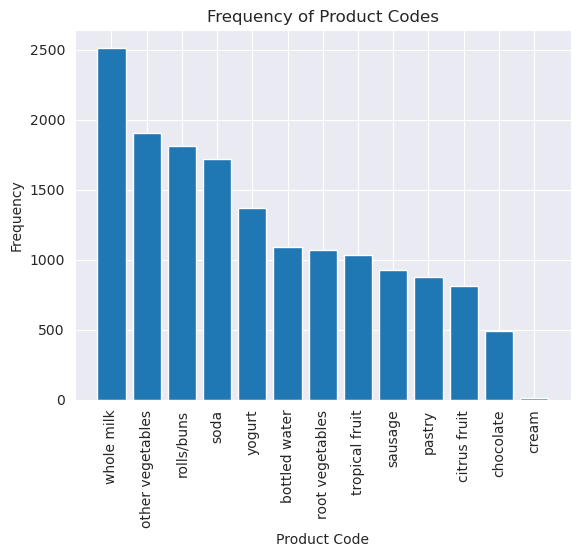

In [113]:
# Calculate the frequency of each product code
product_freq = df_encoded.sum().sort_values(ascending=False)

# Create a bar chart of the frequency of each product code
plt.bar(x=product_freq.index, height=product_freq.values)
plt.xticks(rotation=90)
plt.xlabel("Product Code")
plt.ylabel("Frequency")
plt.title("Frequency of Product Codes")
plt.show()

### Insights:
- Based on the frequency of product codes, we can group them into four categories:
  1. 'Whole Milk'
  2. 'Other Vegetables', 'Rolls/Buns', 'Soda' and 'Yogurt'
  3. 'Bottled Water', 'Root Vegetables', 'Tropical Fruit', 'Sausage', 'Pastry', 'Citrus Fruit' and 'Chocolate'
  4. 'Cream'
- The most commonly purchased product is 'Whole Milk', with a significant difference from the second most common product ('Other Vegetables').
- 'Other Vegetables', 'Rolls/Buns', and 'Soda' are very similarly purchased, making them the second most common products after 'Whole Milk'.
- 'Cream' is the least frequently purchased product, appearing only 13 times out of 7536 baskets.

### Box Plots:
Box plots to identify the distribution of the total value of transactions and recency_days.

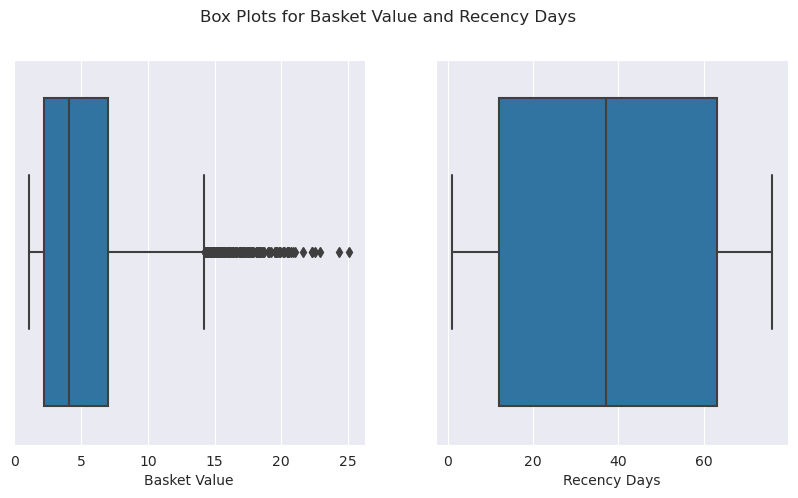

In [114]:
# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Create a box plot for 'basket_value'
sns.boxplot(data=df, x='basket_value', ax=axs[0], orient='h')
axs[0].set_xlabel('Basket Value')

# Create a box plot for 'recency_days'
sns.boxplot(data=df, x='recency_days', ax=axs[1], orient='h')
axs[1].set_xlabel('Recency Days')

# Set the title of the figure
fig.suptitle('Box Plots for Basket Value and Recency Days')

# Display the figure
plt.show()

### Insights:
- The box plot for 'Basket Value' suggests that there are some transactions with very high values, which are considered outliers. These outliers are relatively far from the majority of transactions, indicating a large spread of the data. The majority of transactions appear to have lower values, with the median lying around 4.1 units.
- The box plot for 'Recency Days' displays a distribution that is relatively symmetrical and centered around the median value. Additionally, we can observe that there are no outliers in the data, suggesting that the values for this feature are not excessively high or low compared to the majority of the transactions.
  - Based on this information, we can conclude that the transactions in our dataset were made within a reasonable time frame, neither too long ago nor too recently. In fact, for the majority of the transactions, between 10 to 70 days had elapsed since the transaction took place.

### Line Chart
- Line chart to visualize the trend of total value of transactions over time (The chart is ordered chronologically, with the earliest transactions on the left and the more recent transactions on the right)

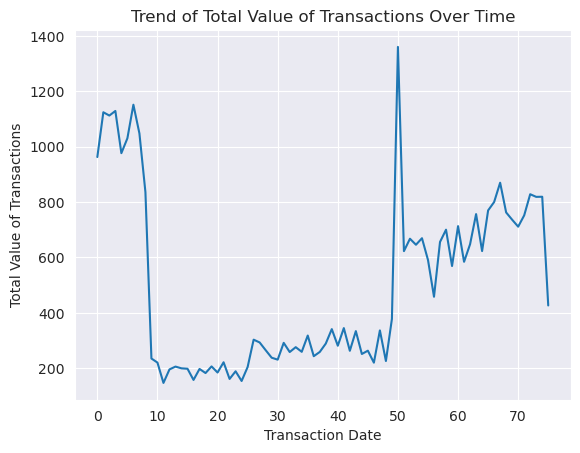

In [115]:
# Create a copy of the original DataFrame
df_date = df.copy()

# Calculate the date of each transaction using the recency_days feature
max_date = df_date.recency_days.max()
df_date['transaction_date'] = max_date - df_date.recency_days

# Group the transactions by the transaction date and sum the basket_value
df_date = df_date.groupby('transaction_date').basket_value.sum().reset_index()

# Create a line chart to visualize the trend of total value of transactions over time
plt.plot(df_date['transaction_date'], df_date['basket_value'])
plt.xlabel('Transaction Date')
plt.ylabel('Total Value of Transactions')
plt.title('Trend of Total Value of Transactions Over Time')
plt.show()

### Observation:
- Until the first 10 days, we observe a high transaction value, which decreases sharply for the next 40 days. Around day 50, it spikes, having the highest transaction value recorded in our data set. Then, it decreases sharply again, following an upward trend, while in the most recent days we observe another decrease in transaction values.
### Insights:
- It seems that there are some periodic trends in the transaction values over time.
- The sharp decrease in transaction values after the first 10 days suggests that customers tend to make more purchases in the first few days after their last purchase.
- Regarding the low transaction values between days 10 and 50, this may indicate a period of lower consumer demand or less active promotion of products. Promotions or targeted marketing campaigns during this time may help to increase transaction values during this period.
- The spike around day 50 could be attributed to a seasonal event or promotion that led to increased sales during that period.
- The upward trend following the spike suggests that customers may have continued to make purchases after the promotion ended.
- The recent decrease in transaction values could indicate a decline in customer interest or a shift in customer preferences.

### Discretization of 'basket_value' column
Differentiate the transaction value (basket_value) into three (approximately) equal categories: low_value_basket, medium_value_basket, high_value_basket.

### KDE Plot
A KDE plot can be helpful to understand the distribution of the basket_value feature.

<Axes: xlabel='basket_value', ylabel='Density'>

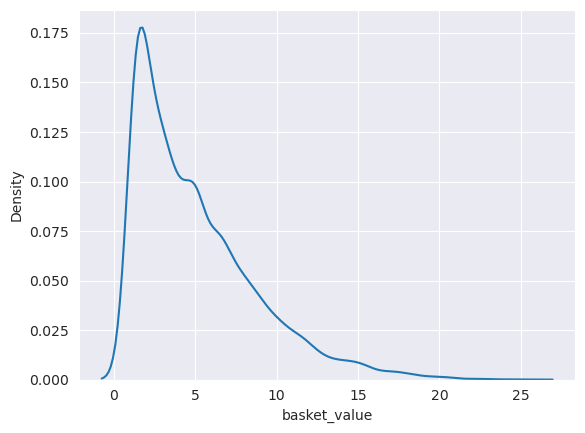

In [116]:
# Create a KDE plot of 'basket_value'
sns.kdeplot(data=df, x='basket_value')

### Equal Sized bins
We will use the `qcut` function from pandas to split the basket_value feature into three equally-sized bins, based on the distribution of the data.

In [117]:
# Split basket_value into three categories
df['basket_category'] = pd.qcut(df['basket_value'], q=3, labels=['low_value_basket', 'medium_value_basket', 'high_value_basket'])

In [118]:
# Check the number of transactions in each category
df['basket_category'].value_counts()

low_value_basket       2572
high_value_basket      2505
medium_value_basket    2459
Name: basket_category, dtype: int64

We observe that the three categories are **almost** equally distributed.

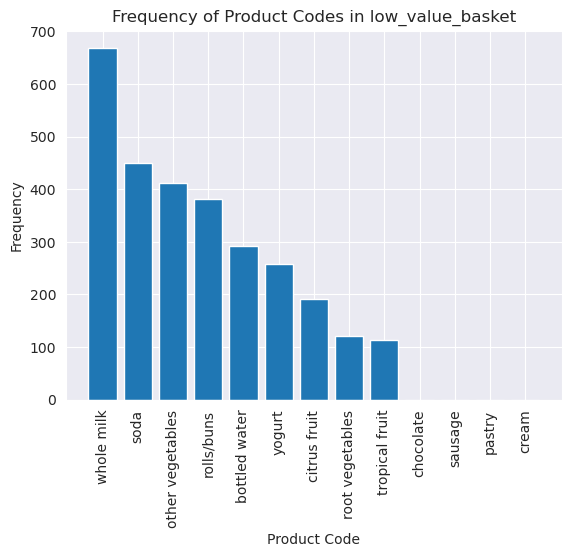

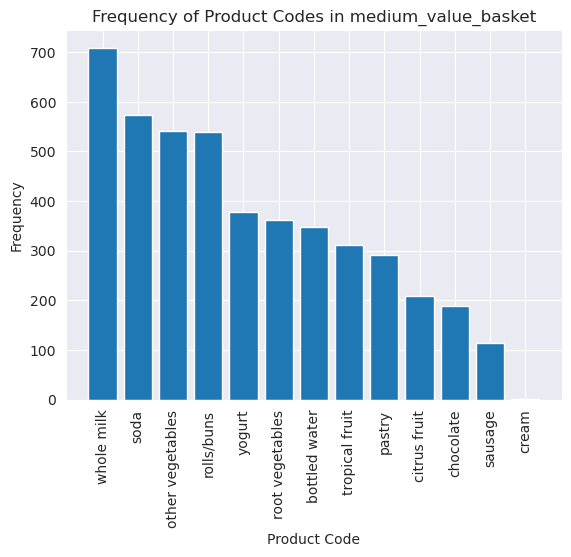

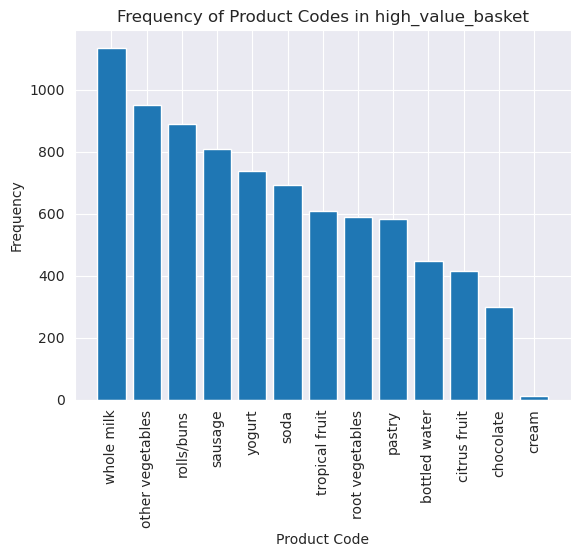

In [119]:
# Concatenate the df_encoded and 'basket_category' column
df_concat = pd.concat([df_encoded, df['basket_category']], axis=1)

# Group by basket_category and calculate the frequency of each product code
grouped = df_concat.groupby('basket_category').sum().T

# Create a bar chart for each basket value
for basket_value in ['low_value_basket', 'medium_value_basket', 'high_value_basket']:
    # Sort the values in descending order
    product_freq = grouped[basket_value].sort_values(ascending=False)

    # Create a bar chart of the frequency of each product code
    plt.bar(x=product_freq.index, height=product_freq.values)
    plt.xticks(rotation=90)
    plt.xlabel("Product Code")
    plt.ylabel("Frequency")
    plt.title(f"Frequency of Product Codes in {basket_value}")
    plt.show()

### Based on the bar plots that we created, we can make several observations:
- The products 'chocolate', 'sausage', 'pastry', and 'cream' are not purchased in the low value basket transactions. This suggests that customers who purchase lower value baskets are less likely to buy these specific products.
- The product 'whole milk' is consistently the most frequent product purchased across all three basket value categories. This suggests that 'whole milk' is a staple item that is commonly purchased by all customers regardless of their basket value.
- Interestingly, 'cream' is not commonly purchased in the medium value basket transactions, but it is purchased in very small amounts in the high value basket transactions. This suggests that customers who purchase higher value baskets may be more willing to purchase 'cream' as an additional item.
- Another interesting observation is that sausage is not present in the medium value basket, but its frequency is very high in the high value basket. This could indicate that sausage is a premium product that is often purchased by high-value customers. It may also suggest that sausage is not frequently purchased by the average customer, but when it is, it tends to be in larger quantities and at a higher price point.
  - This information could be useful for the marketing department when designing promotions or advertising campaigns for sausage or similar premium products.

# <p style="padding:10px;background-color:#D3D3D3 ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:70">2. Learning association rules using the Apriori method</p>

#### Learning association rules exclusively for the characteristics of products and the discretized basket value.

In [120]:
# Create a new dataframe with basket_category and encoded product data
df_products_basket = pd.concat([df['basket_category'], df_encoded], axis=1)

In [121]:
# One hot encode the 'basket_category' column
encoder = OneHotEncoder(sparse_output=False)
basket_category_encoded = encoder.fit_transform(df_products_basket[['basket_category']])

# Create a new dataframe with the encoded values and column names
df_basket_encoded = pd.DataFrame(basket_category_encoded, columns=encoder.get_feature_names_out(['basket_category']))

# Concatenate the encoded dataframe with the original dataframe
df_products_basket_encoded = pd.concat([df_products_basket.drop('basket_category', axis=1), df_basket_encoded], axis=1)

# Convert the encoded dataframe to boolean type
df_products_basket_encoded = df_products_basket_encoded.astype(bool)

In [122]:
df_products_basket_encoded.head()

,citrus fruit,tropical fruit,whole milk,other vegetables,rolls/buns,chocolate,bottled water,yogurt,sausage,root vegetables,pastry,soda,cream,basket_category_high_value_basket,basket_category_low_value_basket,basket_category_medium_value_basket
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True
2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
4,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False


In [123]:
df_products_basket_encoded.shape

(7536, 16)

#### Case 1: running the Apriori method with different parameters for the minimum Support.

In [124]:
# Set the minimum support thresholds to test
min_support_list = [0.01, 0.02, 0.03, 0.04, 0.05]

# Apply the Apriori algorithm to the df_products_basket_encoded dataframe for each minimum support threshold
for min_support in min_support_list:
    frequent_itemsets = apriori(df_products_basket_encoded, min_support=min_support, use_colnames=True)
    print(f"Minimum support: {min_support}")
    print(f"Number of frequent itemsets: {len(frequent_itemsets)}")

Minimum support: 0.01
Number of frequent itemsets: 277
Minimum support: 0.02
Number of frequent itemsets: 139
Minimum support: 0.03
Number of frequent itemsets: 91
Minimum support: 0.04
Number of frequent itemsets: 61
Minimum support: 0.05
Number of frequent itemsets: 46


### Observations:
- From the results, we can see that as the minimum support threshold increases, the number of frequent itemsets decreases. This is because higher minimum support values require a higher frequency of occurrence for an itemset to be considered frequent.
- When the minimum support is set to 0.01, we get the highest number of frequent itemsets, which indicates that there are many combinations of products that appear frequently in baskets. As the minimum support increases, the number of frequent itemsets decreases, indicating that fewer combinations of products appear frequently in baskets.

#### Case 2:  finding the top 20 rules with the highest confidence exclusively for the products.

In [125]:
# Run Apriori with a minimum support of 0.01
frequent_itemsets = apriori(df_encoded.astype(bool), min_support=0.01, use_colnames=True)

# Generate association rules with a minimum confidence of 0.4
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)

# Sort the rules by confidence in descending order and select the top 20
top_rules = rules.sort_values('confidence', ascending=False)[:20]

# Print the top rules
top_rules[['antecedents', 'consequents', 'confidence']]

,antecedents,consequents,confidence
40,"(yogurt, other vegetables, root vegetables)",(whole milk),0.606299
10,"(citrus fruit, root vegetables)",(other vegetables),0.586207
18,"(root vegetables, tropical fruit)",(other vegetables),0.584541
16,"(root vegetables, tropical fruit)",(whole milk),0.570048
31,"(yogurt, root vegetables)",(whole milk),0.562992
39,"(whole milk, yogurt, root vegetables)",(other vegetables),0.538462
27,"(root vegetables, rolls/buns)",(whole milk),0.523013
15,"(yogurt, tropical fruit)",(whole milk),0.517361
32,"(yogurt, pastry)",(whole milk),0.517241
9,"(citrus fruit, root vegetables)",(whole milk),0.517241


### Observations:
- We can see that many of the rules involve "whole milk", which was the most frequent bought product in the dataset. This indicates that customers who buy "whole milk" are also likely to buy other products, such as "yogurt", "root vegetables", and "other vegetables".
- One of the interesting rules with a high confidence is "(yogurt, root vegetables, other vegetables) -> (whole milk)" with a confidence of 0.606299. This means that if a customer buys yogurt, root vegetables, and other vegetables together, there is a 60.63% chance that they will also buy whole milk.

  - This rule impressed me the most and it may be useful for the store to plan their product placements or promotions. For example, they could place yogurt, root vegetables, and other vegetables in the same aisle as whole milk or offer a promotion where customers who buy all four items together get a discount.

- Another interesting rule is "(root vegetables, tropical fruit) -> (whole milk)" with a confidence of 0.570048. This rule suggests that customers who buy root vegetables and tropical fruit together are also likely to buy whole milk.
  - The store could consider promoting these items together, perhaps by creating a recipe that includes all three ingredients.

Overall, the top rules suggest that there are certain product combinations that customers are more likely to purchase together, and the store could use this information to optimize their sales strategy.

#### Case 3:  finding the top 20 rules with the highest confidence for the products and for the discretized basket value.

##### Running the apriori algorithm with the same setup of thresholds as we did before.

In [126]:
# Run Apriori with a minimum support of 0.01
frequent_itemsets = apriori(df_products_basket_encoded, min_support=0.01, use_colnames=True)

# Generate association rules with a minimum confidence of 0.4
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)

# Sort the rules by confidence in descending order and select the top 20
top_rules = rules.sort_values('confidence', ascending=False)[:20]

# Print the top rules
top_rules[['antecedents', 'consequents', 'confidence']]

,antecedents,consequents,confidence
230,"(sausage, soda, rolls/buns)",(basket_category_high_value_basket),1.0
198,"(whole milk, sausage, yogurt)",(basket_category_high_value_basket),1.0
52,"(sausage, tropical fruit)",(basket_category_high_value_basket),1.0
54,"(tropical fruit, pastry)",(basket_category_high_value_basket),1.0
32,"(citrus fruit, sausage)",(basket_category_high_value_basket),1.0
125,"(sausage, soda)",(basket_category_high_value_basket),1.0
124,"(sausage, pastry)",(basket_category_high_value_basket),1.0
123,"(sausage, root vegetables)",(basket_category_high_value_basket),1.0
177,"(whole milk, sausage, other vegetables)",(basket_category_high_value_basket),1.0
119,"(sausage, yogurt)",(basket_category_high_value_basket),1.0


### Observations:
- One combination that stands out is "(soda, rolls/buns, sausage)" as the antecedents and "(basket_category_high_value_basket)" as the consequent, with a confidence value of 1.0. This rule suggests that if a customer buys soda, rolls/buns, and sausage, then they are very likely to buy products from the high-value basket category.
  - This could be a useful insight for the retailer to consider placing them in close proximity to each other to encourage customers to purchase more items from the high-value basket category.
- Other notable combinations include "(yogurt, whole milk, sausage)" and "(tropical fruit, sausage)", both with a confidence value of 1.0. These rules suggest that if a customer buys yogurt, whole milk, and sausage or tropical fruit and sausage, then they are highly likely to purchase products from the high-value basket category.
- It's also interesting to note that all of the top 20 rules have a confidence value of 1.0, indicating that the antecedents and consequents are always bought together. This could suggest that the minimum support and confidence thresholds used in the code may be too low, and a higher threshold may be needed to find more meaningful association rules.
  - Therefore, we decide to run again apriori with different values for the minimum support and confidence thresholds.

### We are finding again the top 20 rules with the highest confidence for the products and for the discretized basket value, but this time we set higher values for the minimum support and confidence.
- By setting a higher minimum support threshold of 0.03, we are only considering frequent itemsets that appear in at least 3% of the transactions, which should filter out less meaningful associations.
- Similarly, by setting a higher minimum confidence threshold of 0.6, we are only considering rules where the antecedent and consequent are bought together in at least 60% of the transactions where the antecedent appears, which should filter out weaker associations.

In [127]:
# Run Apriori with a minimum support of 0.03
frequent_itemsets = apriori(df_products_basket_encoded, min_support=0.03, use_colnames=True)

# Generate association rules with a minimum confidence of 0.6
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Sort the rules by confidence in descending order and select the top 20
top_rules = rules.sort_values('confidence', ascending=False)[:20]

# Print the top rules
top_rules[['antecedents', 'consequents', 'confidence']]

,antecedents,consequents,confidence
21,"(sausage, soda)",(basket_category_high_value_basket),1.000000
9,"(whole milk, sausage)",(basket_category_high_value_basket),1.000000
19,"(sausage, rolls/buns)",(basket_category_high_value_basket),1.000000
15,"(sausage, other vegetables)",(basket_category_high_value_basket),1.000000
1,(sausage),(basket_category_high_value_basket),0.875541
11,"(whole milk, pastry)",(basket_category_high_value_basket),0.844037
5,"(yogurt, tropical fruit)",(basket_category_high_value_basket),0.798611
3,"(whole milk, tropical fruit)",(basket_category_high_value_basket),0.769231
4,"(other vegetables, tropical fruit)",(basket_category_high_value_basket),0.764873
18,"(yogurt, rolls/buns)",(basket_category_high_value_basket),0.757396


### Observations:
- One combination that stands out is "(soda, sausage)" being associated with the "basket_category_high_value_basket". This combination has a confidence value of 1.0, indicating that whenever a customer buys soda and sausage together, they are very likely to have a high value basket.
  - This may be because soda and sausage are not typically considered healthy items, and customers may be more likely to indulge in other high-value items such as gourmet foods or specialty products when buying these items.
- Another interesting combination is "(pastry, whole milk)" being associated with the "basket_category_high_value_basket". This combination has a confidence value of 0.84, indicating that whenever a customer buys pastry and whole milk together, they are highly likely to have a high value basket.
  - This may be because pastry and whole milk are often used in baking and cooking, and customers may be more likely to purchase other baking ingredients or cooking staples when buying these items.
- Overall, these association rules can provide valuable insights for the retailer to improve their product offerings, promotions, and store layouts. For example, they may want to place high-value items such as gourmet foods or specialty products near the soda and sausage section to encourage customers to purchase more high-value items. They may also want to offer promotions or bundling deals on pastry and whole milk to increase the likelihood of customers purchasing high-value items in the same transaction.

### What is possibly the most expensive product and why?
- Based on the association rules generated by the apriori algorithm, it appears that **sausage** is strongly associated with the high basket value category with a confidence of 1.0, which means that every transaction that includes both sausage and any other item in the antecedents will also include an item in the consequent (high basket value category) with 100% certainty.
- Therefore, it's possible to say that **sausage** is probably the most expensive product.

### Case 4: Conclusions of the association analysis.

### What conclusions can you draw based on the rules?
1. The most frequent item in the dataset is "whole milk", which appears in many of the top association rules. This suggests that "whole milk" is a product that customers tend to buy frequently.
2. The product "sausage" appears in several of the top association rules, especially when considering its association with the high-value basket category. This suggests that "sausage" may be a more expensive product that customers tend to buy when they are making larger purchases.
3. The association rules suggest that certain product combinations are more likely to be purchased together, such as "soda" and "sausage", "rolls/buns" and "sausage", and "other vegetables" and "sausage". This information can be used to optimize product placement in the store, such as placing these products in close proximity to each other to encourage customers to buy them together.
4. The association rules also suggest that certain product combinations have a high confidence, indicating a strong association between the two products. For example, "pastry" and "whole milk" have a confidence of 0.844037, indicating that customers who buy "pastry" are highly likely to also buy "whole milk".

### Are they consistent with your initial analysis?
- Overall, these conclusions are consistent with the initial analysis. The initial analysis identified "whole milk" as the most frequently purchased item and suggested that certain products may be more expensive and purchased together. The association rules provide additional detail and support for these findings.

### How do the trends differ and why?
- We have examined three cases:
  1. running the Apriori method with different parameters for the minimum Support
  2. finding the top 20 rules with the highest confidence exclusively for the products
  3. finding the top 20 rules with the highest confidence for the products and for the discretized basket value
- The trends differ in the three cases because different metrics and thresholds were used to generate the association rules.
- In case 1, we varied the minimum support threshold, which resulted in different frequent itemsets and association rules being generated.
- In case 2, we focused exclusively on product associations and did not consider the basket value.
- In case 3, we included the basket value as a factor and generated association rules that consider the relationship between products and basket value.
- When we compare the two sets of rules from case 1 and case 2, we can see that the products that are commonly associated with high-value baskets are different from the products that are commonly bought together in general. This may indicate that customers who buy high-value baskets have different preferences and shopping habits than customers who buy low-value baskets.

# <p style="padding:10px;background-color:#D3D3D3 ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:70">3. Clustering transactions using the k-means method</p>

#### In the processed dataset, we are called to discover groups of transactions that may be of particular interest to the Marketing department, e.g. high-value transactions that occurred in the past but are not happening today. Then, we will describe the profile of the discovered groups.

### Apply the k-means clustering method to the two continuous features `basket_value` and `recency_days` to extract 5 transaction groups. Briefly describe the process you followed and the output you obtained from Python - exactly as you obtained it. Additionally, present the results with plots.

### Scatter plot of the two continuous features `basket_value` and `recency_days`

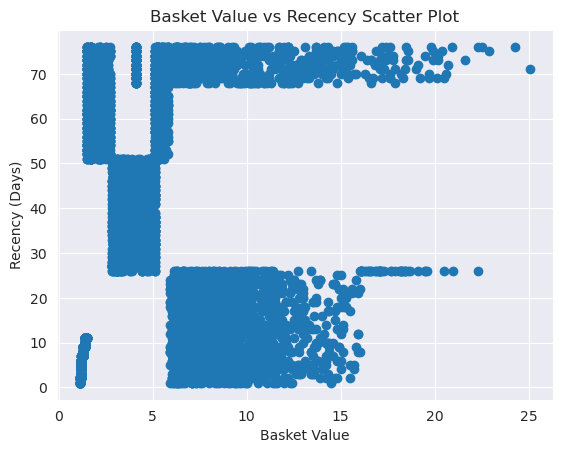

In [128]:
# Plot scatter plot of basket_value vs recency_days
plt.scatter(df['basket_value'], df['recency_days'])
plt.xlabel('Basket Value')
plt.ylabel('Recency (Days)')
plt.title('Basket Value vs Recency Scatter Plot')
plt.show()

#### We observe that the groups have different sizes, different densities, non-spherical shapes, and there are data with extreme values (outliers). K-Means is not the best choice for this kind of data, but we can try to preprocess the data to make it more suitable for k-means algorithm.

### Remove outliers:
We can remove the outliers from the data before applying k-means algorithm. This will reduce the effect of extreme values on the cluster centers.

#### KDE plot for each feature

<Axes: xlabel='basket_value', ylabel='Density'>

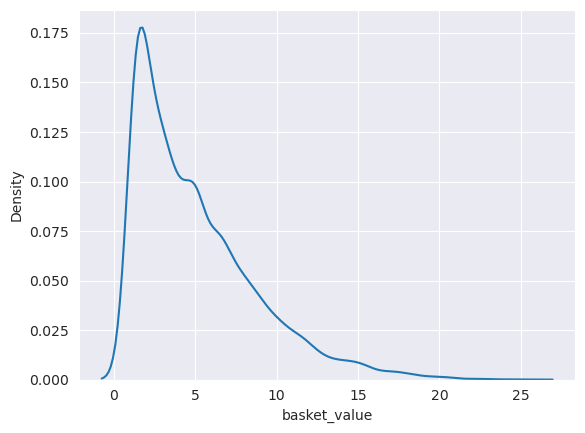

In [129]:
# Plot a KDE plot for basket_value
sns.kdeplot(df['basket_value'])

<Axes: xlabel='recency_days', ylabel='Density'>

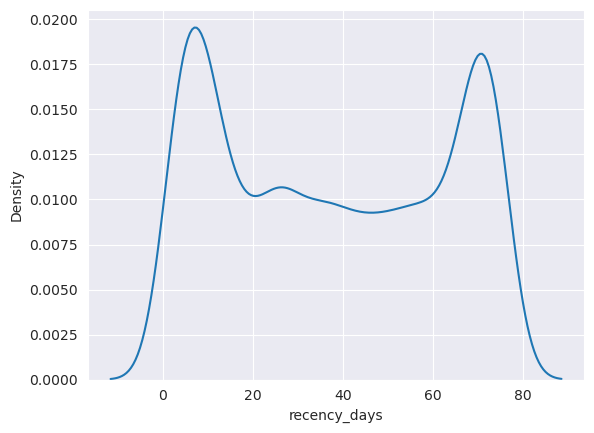

In [130]:
# Plot a KDE plot for recency_days
sns.kdeplot(df['recency_days'])

In [131]:
# Calculate z-scores for basket_value
z_scores_bv = stats.zscore(df['basket_value'])

# Define a threshold for the z-score
threshold = 3

# Create a boolean array indicating which rows to keep
keep_rows = abs(z_scores_bv) < threshold

# Create new column for basket_value without outliers
df['basket_value_no_outliers'] = df['basket_value'][keep_rows]

# Remove corresponding rows from recency_days
df['recency_days_no_outliers'] = df['recency_days'][keep_rows][~pd.isnull(df['basket_value_no_outliers'])]

#### Generating a KDE plot for the basket_value both with and without the outliers, and upon comparison, it can be observed that the right tail of the distribution is now shorter.

<Axes: xlabel='basket_value_no_outliers', ylabel='Density'>

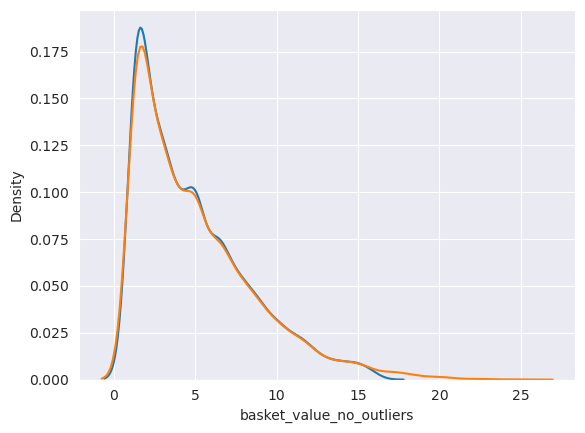

In [132]:
# Plot a KDE plot for basket_value
sns.kdeplot(df['basket_value_no_outliers'])
# Plot a KDE plot for basket_value
sns.kdeplot(df['basket_value'])

### Doing again a scatter plot of the two continuous features `basket_value` and `recency_days`
After the Outlier removal the clustering process could be more effective, as shown in the following plot.

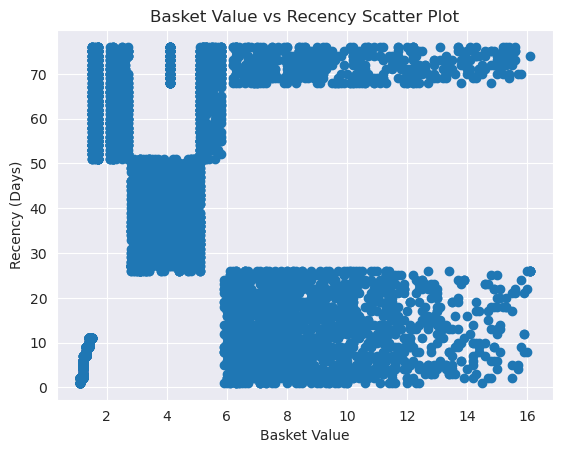

In [133]:
# Plot scatter plot of basket_value vs recency_days
plt.scatter(df['basket_value_no_outliers'], df['recency_days_no_outliers'])
plt.xlabel('Basket Value')
plt.ylabel('Recency (Days)')
plt.title('Basket Value vs Recency Scatter Plot')
plt.show()

### Scale the features (ensures that the features are in the range of 0 to 1):
We can scale the features basket_value and recency_days so that they have the same range of values. This will prevent k-means algorithm from assigning more weight to one feature over the other.

In [134]:
# selecting only the two continuous features
df_no_outliers = df.loc[keep_rows, ['basket_value_no_outliers', 'recency_days_no_outliers']].copy()

# Initialize scaler
scaler = MinMaxScaler()

# Scale the features
X_scaled = scaler.fit_transform(df_no_outliers)

# Convert the numpy array to a dataframe
X_scaled = pd.DataFrame(X_scaled, columns=df_no_outliers.columns)

In [135]:
X_scaled.head()

,basket_value_no_outliers,recency_days_no_outliers
0,0.000000,0.013333
1,0.166667,0.400000
2,0.006667,0.080000
3,0.366667,0.080000
4,0.093333,0.866667


### Elbow Method
Next, we use the elbow method to determine the optimal number of clusters to use:
This involves plotting the within-cluster sum of squares (WCSS) for different numbers of clusters and selecting the number of clusters where the decrease in WCSS begins to level off.

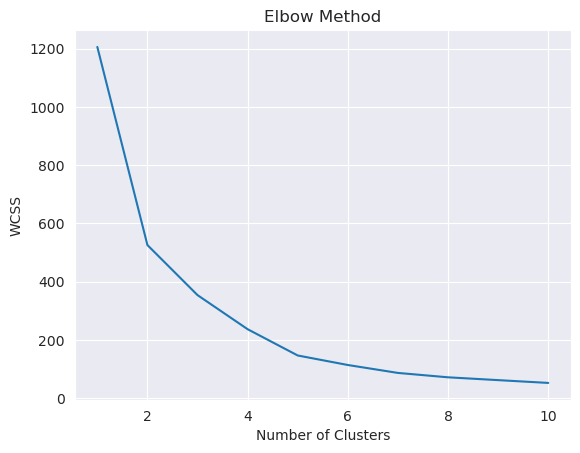

In [136]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

### Observation:
- We see that the drop in SSE after k=5 is marginal. Therefore, we may choose 5 clusters (as described in the assignment's description).

### Applying the k-means clustering method to the X_scaled  to extract 5 transaction groups

In [137]:
# Apply k-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, n_init='auto',random_state=42)
kmeans.fit(X_scaled)

# Add the cluster labels to the original dataframe
df_no_outliers['cluster'] = kmeans.labels_

In [138]:
df_no_outliers.head()

,basket_value_no_outliers,recency_days_no_outliers,cluster
0,1.1,2.0,4
1,3.6,31.0,1
2,1.2,7.0,4
3,6.6,7.0,3
4,2.5,66.0,2


### Plot the clusters using a scatter plot

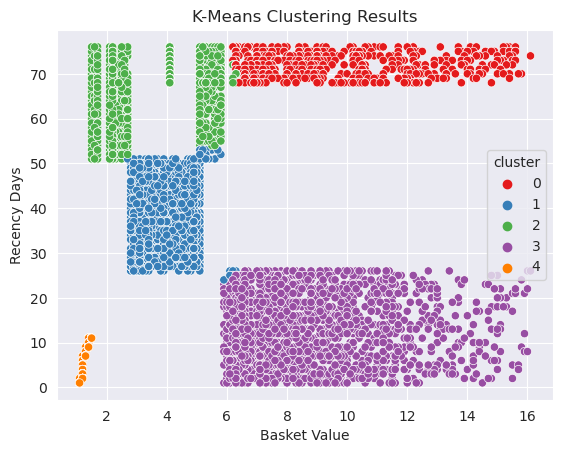

<Figure size 1000x800 with 0 Axes>

In [139]:
# Plot the clusters using a scatter plot
sns.scatterplot(x='basket_value_no_outliers', y='recency_days_no_outliers', hue='cluster', data=df_no_outliers, palette='Set1')

# Add axis labels and a title to the plot
plt.xlabel('Basket Value') # without scaling
plt.ylabel('Recency Days') # without scaling
plt.title('K-Means Clustering Results')

# Set figure size
plt.figure(figsize=(10, 8))

plt.show()

### Observations:
- We have a very small cluster (cluster #4), which someone could consider as a cluster that contains outliers.
- We have a cluster (cluster #0) of transactions that were made earlier compared to the rest of the transactions in the dataset (high value in the Recency Days feature) and have a high transaction value.
- We have a cluster (cluster #3) of transactions that were made more recently compared to the rest of the transactions in the dataset (low value in the Recency Days feature) and also have a high transaction value.
- However, between these two clusters, there are two clusters (cluster #1 and #2) of transactions that are chronologically located between clusters #0 and #3 and have transactions of small and medium value. That is, there is a period of about 40 days where sales declined significantly (as we observed earlier on the line chart of 'Recency Days' with 'Basket Value'), indicating a shift in customer behavior in the recent past.
  - This could be an important insight for the business to consider for their marketing and sales strategy. Additionally, the small and medium value transactions in clusters #1 and #2 could be targeted by offering promotions or discounts to encourage more sales.

### Briefly, describing the process we followed:
1. Scatter plot of the two continuous features basket_value and recency_days: We plotted a scatter plot of the two continuous features to visually explore the data and identify any patterns or trends.
2. Remove outliers: We identified outliers using z-scores and removed them from the dataset to avoid them having a significant impact on the clustering algorithm.
3. Scale the features: We scaled the two features so that they have the same range of values. This will prevent k-means algorithm from assigning more weight to one feature over the other.
4. Elbow Method: We used the Elbow Method to determine the optimal number of clusters for the data (We chose k=5 - the same as the assignment's description).
5. Applying the k-means clustering method: We applied the k-means clustering method with the optimal number of clusters to group the transactions.
6. Plot the clusters using a scatter plot: We plotted the resulting clusters using a scatter plot to visually examine the results of the clustering and identify any patterns or trends.

### For the clustering of 5 groups that we ended up with, we report the mean value of the centers of the groups that were obtained and their standard deviation.

In [140]:
# Get the coordinates of the centroids in the scaled space
centroids_scaled = kmeans.cluster_centers_

# Transform the centroids back to the original scale
centroids = scaler.inverse_transform(centroids_scaled)

# Create a DataFrame with the centroids and their cluster labels
centroids_df = pd.DataFrame(centroids, columns=['basket_value (coordinate)', 'recency_days(coordinate)'])
centroids_df['cluster'] = range(5)

# Compute the mean and standard deviation of the features for each cluster
stats_df = df_no_outliers.groupby('cluster').agg({'basket_value_no_outliers': ['mean', 'std'], 'recency_days_no_outliers': ['mean', 'std']})
stats_df.columns = ['basket_value_mean', 'basket_value_std', 'recency_days_mean', 'recency_days_std']

# Join the stats DataFrame with the centroids DataFrame
results_df = centroids_df.merge(stats_df, on='cluster')

# Display the results
results_df

,basket_value (coordinate),recency_days(coordinate),cluster,basket_value_mean,basket_value_std,recency_days_mean,recency_days_std
0,9.847368,72.107212,0,9.840661,2.719291,72.099222,2.540103
1,3.869738,38.381896,1,3.869738,0.783293,38.381896,7.481693
2,2.882323,65.026119,2,2.880681,1.465759,65.024732,7.203708
3,8.724493,13.330309,3,8.724493,2.352210,13.330309,7.319515
4,1.262428,6.298651,4,1.262428,0.098075,6.298651,3.003922


The DataFrame `results_df` contains the mean and standard deviation of the basket_value and recency_days features for each cluster, as well as the coordinates of the centroids in the original scale.

### Interpreting the clusters through them the mean value of the centers of the groups that were obtained and their standard deviation.

### Based on the mean value of the centers of the groups that were obtained and their standard deviation, we can interpret the clusters as follows:
1. Cluster 0: This cluster represents customers with the highest basket value and higher recency days. These customers have made purchases in the past but haven't made any recently. The mean value of the basket_value_mean is 9.84, which is the highest among all the clusters, while the recency_days_mean is 72.09, which is also the highest. The standard deviation of the basket value is 2.72, which indicates that there is a significant variation in the purchase amounts of these customers.
2. Cluster 1: This cluster represents customers with small basket value and low recency days. These are customers who made recent purchases but with small basket value. The mean value of the basket_value_mean is 3.87, which is the lowest among all the clusters, while the recency_days_mean is 38.38, which is not the lowest but still relatively low. The standard deviation of the basket value is 0.78, which indicates that there is not much variation in the purchase amounts of these customers.
3. Cluster 2: This cluster represents customers with a low basket value and higher recency days. These are customers who have not made any recent purchases and have low purchase amounts. The mean value of the basket_value_mean is 2.88, which is the second-lowest among all the clusters, while the recency_days_mean is 65.02, which is relatively high. The standard deviation of the basket value is 1.47, which indicates that there is some variation in the purchase amounts of these customers.
4. Cluster 3: This cluster represents customers with a high basket value and low recency days. These are customers who have made recent purchases and have high purchase amounts. The mean value of the basket_value_mean is 8.72, which is the second-highest among all the clusters, while the recency_days_mean is 13.33, which is the lowest. The standard deviation of the basket value is 2.35, which indicates that there is some variation in the purchase amounts of these customers.
5. Cluster 4: This cluster represents a very small number of transactions. It is possible to consider this as a cluster that contains outliers, as the mean value of the basket_value_mean and the recency_days_mean are the lowest among all the clusters, and the standard deviation of the basket value is also the lowest, which indicates that there is no variation in the purchase amounts of these customers.

###  Is there any concerning group of transactions that the Marketing department should address, such as high-value transactions that occurred in the past?
- Yes, there is a concerning group of transactions that the Marketing department should address. Cluster 0 has the highest mean value of basket value and the highest mean value of recency days, which means that these are high-value transactions that occurred a long time ago. This may indicate that these customers have not made any recent purchases and may have switched to a competitor or lost interest in the company's products/services. Therefore, the Marketing department should take action to try to re-engage with these customers and encourage them to make new purchases.

### Export the assignments to a group for each transaction in a new qualitative variable (column) so that learning association rules is possible on this new feature. To have the appropriate format, you should store the group of each transaction using 5 characteristic variables (Cluster0, Cluster1, etc.) to enable the application of association rules, i.e., you should also produce the binary format of the transactions.

In [141]:
# keeping only the rows that does not contaiin outliers
df_final = df.loc[keep_rows].copy()

# get the cluster of each row
df_final['cluster'] = df_no_outliers['cluster']

# create an instance of the one-hot encoder
encoder = OneHotEncoder(sparse_output=False)

# fit the encoder on the cluster column of the dataframe
encoder.fit(df_final[['cluster']])

# transform the cluster column into a one-hot encoded array
cluster_encoded = encoder.transform(df_final[['cluster']])

# get the names of the encoded cluster columns
cluster_names = encoder.get_feature_names_out(['cluster'])

# concatenate the one-hot encoded array with the original dataframe
df_final = pd.concat([df_final.reset_index(drop=True), pd.DataFrame(cluster_encoded, columns=cluster_names)], axis=1)

# dropping some unnecessary columns
df_final = df_final.drop(['recency_days_no_outliers', 'basket_value_no_outliers', 'cluster'], axis=1)

In [142]:
df_final.head()

,id,basket_value,recency_days,Item_1,Item_2,Item_3,Item_4,Item_5,Item_6,Item_7,...,Item_29,Item_30,Item_31,Item_32,basket_category,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,1,1.1,2,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,low_value_basket,0.0,0.0,0.0,0.0,1.0
1,2,3.6,31,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,medium_value_basket,0.0,1.0,0.0,0.0,0.0
2,3,1.2,7,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,low_value_basket,0.0,0.0,0.0,0.0,1.0
3,4,6.6,7,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,high_value_basket,0.0,0.0,0.0,1.0,0.0
4,5,2.5,66,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,low_value_basket,0.0,0.0,1.0,0.0,0.0


In [143]:
df_final.shape # we have not included the rows containing outlier values

(7436, 41)

In [144]:
# Load data into a list of lists
# Select the columns of interest and convert each non-NaN value to a string
transactions = df_final.iloc[:, 3:35].apply(lambda row: [str(val) for val in row.dropna()], axis=1).tolist()

# Encode the data set using TransactionEncoder
te = TransactionEncoder()  # Create a TransactionEncoder object
te_ary = te.fit(transactions).transform(transactions)  # Fit and transform the data using TransactionEncoder
df_encoded = pd.DataFrame(te_ary.astype("int"), columns=te.columns_)  # Convert the NumPy array to a pandas DataFrame with column names

# Create a new data frame with only the columns of interest (as we did before)
df_encoded = df_encoded[product_codes]

# show the first 5 rows
df_encoded.head() # transactions in binary format (without the cluster assignments)

,citrus fruit,tropical fruit,whole milk,other vegetables,rolls/buns,chocolate,bottled water,yogurt,sausage,root vegetables,pastry,soda,cream
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,0,0,0


In [145]:
# df_encoded contains only the product codes in a binary format, so we concatenate the cluster assignment
df_products_cluster_encoded = pd.concat([df_encoded, df_final[['cluster_0','cluster_1','cluster_2','cluster_3','cluster_4']]], axis=1)

# show the first 5 rows
df_products_cluster_encoded.head() # transactions and cluster assignments in binary format

,citrus fruit,tropical fruit,whole milk,other vegetables,rolls/buns,chocolate,bottled water,yogurt,sausage,root vegetables,pastry,soda,cream,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
4,0,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0


# <p style="padding:10px;background-color:#D3D3D3 ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:70">4. Combined utilization of methods: Description of product and general profile of groups using association rules.</p>

### In the dataset resulting(df_products_cluster_encoded), we will try to describe the product profile of each transaction group using association rules.

### Case 1: Using the Apriori method, find the top 20 rules with the highest confidence exclusively for products and transaction groups.

In [146]:
# Run Apriori with a minimum support of 0.01
frequent_itemsets = apriori(df_products_cluster_encoded.astype(bool), min_support=0.01, use_colnames=True)

# Generate association rules with a minimum confidence of 0.8
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)

# Sort the rules by confidence in descending order and select the top 20
top_rules = rules.sort_values('confidence', ascending=False)[:20]

# Print the top rules
top_rules[['antecedents', 'consequents', 'confidence']]

,antecedents,consequents,confidence
0,(cluster_0),(pastry),1.000000
9,"(other vegetables, cluster_0)",(pastry),1.000000
30,"(whole milk, other vegetables, pastry)",(cluster_0),1.000000
29,"(whole milk, other vegetables, cluster_0)",(pastry),1.000000
24,"(soda, cluster_0)",(pastry),1.000000
22,"(cluster_0, root vegetables)",(pastry),1.000000
20,"(sausage, pastry)",(cluster_0),1.000000
19,"(sausage, cluster_0)",(pastry),1.000000
12,"(cluster_0, rolls/buns)",(pastry),1.000000
16,"(yogurt, cluster_0)",(pastry),1.000000


### What products or combinations of products are primarily purchased by each group?
- According to the association rules generated by Apriori, we can see that the group with the highest confidence of purchasing a specific product is Cluster 0, which is associated with the purchase of pastry.
- Moreover, we can see that there are some associations between Cluster 0 and other products such as soda, root vegetables, tropical fruit, yogurt, and whole milk.
- For Cluster 3, sausage seems to be the most purchased product, as it appears in several rules. Additionally, there are several combinations of products that are exclusively purchased by this group, such as rolls/buns, soda, and sausage, other vegetables and sausage, citrus fruit and sausage, and so on. This suggests that this group may have a preference for meat products and may be interested in barbecues and outdoor activities.
- For the other clusters, we do not have rules with such a high level of confidence.

###  Previously, during the clustering analysis, we identified a concerning group of transactions (Cluster 0). With which product is it usually associated?
- Based on the association rules we found earlier, we can see that the concerning group of transactions (Cluster 0) is primarily associated with the purchase of pastries. In fact, the top 10 rules with the highest confidence all involve the purchase of pastries along with Cluster 0.
- This information, combined with the fact that Cluster 0 has the highest mean value of basket value and the highest mean value of recency days, suggests that these high-value transactions occurred a long time ago and that these customers have not made any recent purchases. It's possible that there has been a decline in the popularity of pastries among customers, leading to a decrease in sales and a decrease in the frequency of purchases by customers in this group.
- To address this issue, the Marketing department should investigate the reasons behind the decline in popularity and look for ways to re-engage with these customers, possibly by introducing new pastry products or launching a promotional campaign to attract them back to the store.

### Case 2: Find the top 20 rules with the highest confidence for the products, transaction groups, and distinct basket value.

In [147]:
# One hot encode the 'basket_category' column
encoder = OneHotEncoder(sparse_output=False)
basket_category_encoded = encoder.fit_transform(df_final[['basket_category']])

# Create a new dataframe with the encoded values and column names
df_basket_encoded = pd.DataFrame(basket_category_encoded, columns=encoder.get_feature_names_out(['basket_category']))

# Concatenate the encoded dataframe with the original dataframe
df_products_cluster_basket_encoded = pd.concat([df_products_cluster_encoded, df_basket_encoded], axis=1)

# show the first 5 rows
df_products_cluster_basket_encoded.head()

,citrus fruit,tropical fruit,whole milk,other vegetables,rolls/buns,chocolate,bottled water,yogurt,sausage,root vegetables,...,soda,cream,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,basket_category_high_value_basket,basket_category_low_value_basket,basket_category_medium_value_basket
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [148]:
# Run Apriori with a minimum support of 0.01
frequent_itemsets = apriori(df_products_cluster_basket_encoded.astype(bool), min_support=0.01, use_colnames=True)

# Generate association rules with a minimum confidence of 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort the rules by confidence in descending order and select the top 20
top_rules = rules.sort_values('confidence', ascending=False)[:20]

# Print the top rules
top_rules[['antecedents', 'consequents', 'confidence']]

,antecedents,consequents,confidence
124,"(other vegetables, cluster_3)",(basket_category_high_value_basket),1.0
479,"(soda, cluster_3, yogurt)",(basket_category_high_value_basket),1.0
220,"(basket_category_medium_value_basket, pastry)",(cluster_2),1.0
489,"(sausage, pastry)","(cluster_0, basket_category_high_value_basket)",1.0
488,"(sausage, cluster_0)","(basket_category_high_value_basket, pastry)",1.0
120,"(other vegetables, cluster_0)",(basket_category_high_value_basket),1.0
305,"(cluster_0, tropical fruit)","(basket_category_high_value_basket, pastry)",1.0
487,"(sausage, basket_category_high_value_basket, p...",(cluster_0),1.0
250,"(citrus fruit, cluster_3, sausage)",(basket_category_high_value_basket),1.0
126,"(cluster_4, other vegetables)",(basket_category_low_value_basket),1.0


### Observations:
- Many of the rules involve high-value baskets, indicating that certain products or combinations of products are more likely to be purchased in high-value transactions.
- Sausage and pastry appear frequently in the rules, suggesting that these products may be popular together and may contribute to high-value baskets.
- Certain clusters, such as cluster 0 and cluster 3, appear frequently in the rules, indicating that these groups of customers have particular product preferences or behaviors that are associated with high-value baskets. That was something that we also spotted during the clustering analysis.